# Labelling training data
Given the relatively small size of our training data, we manually labelled the training data.

In [ ]:
# Install imaging library Pillow
%pip install pillow

In [ ]:
import os
from PIL import Image
import xml.etree.ElementTree as ET

In [ ]:
# Training data from Kaggle
unlabeled_data_folder = os.path.join("Data", "train")

# XML files created by LabelIMG
data_labels_folder = os.path.join("Labelled_Training_Data")

# Cropped images sorted by coin type
extracted_data_folder = os.path.join("Extracted_Training_Data")
os.makedirs(extracted_data_folder, exist_ok=True)

In [ ]:
def crop_and_save_image(input_image_path, output_folder, object_list):
    # Open the input image
    with Image.open(input_image_path) as img:
        for index, object in enumerate(object_list):
            # Crop the image
            name = object['name']
            cropped_img = img.crop((int(object['xmin']), int(object['ymin']), int(object['xmax']), int(object['ymax'])))
            output_coin_type = os.path.join(output_folder, name)
            # Ensure the output folder exists
            os.makedirs(output_coin_type, exist_ok=True)
            
            # Construct the output image path, weird naming to avoid duplicates from same image, index placed before filetype
            image_name = os.path.basename(input_image_path[:-4]) + '_' + str(index) + '.JPG'
            output_image_path = os.path.join(output_coin_type, image_name)
            
            # Save the cropped image
            cropped_img.save(output_image_path)
            print(f'Cropped image saved to: {output_image_path}')

In [ ]:
def read_xml_file_content(filepath):
    tree = ET.parse(filepath)
    root = tree.getroot()
    object_list = []
    for object in root.findall('object'):
        d = dict()
        d['name'] = object.findtext('name')
        bounding_box = object.find('bndbox')
        d['xmin'] = bounding_box.findtext('xmin')
        d['ymin'] = bounding_box.findtext('ymin')
        d['xmax'] = bounding_box.findtext('xmax')
        d['ymax'] = bounding_box.findtext('ymax')
        object_list.append(d)

    return object_list

In [ ]:
for folder in os.listdir(unlabeled_data_folder):
    label_folder = os.path.join(data_labels_folder, folder)
    folder = os.path.join(unlabeled_data_folder, folder)
    for image in os.listdir(folder):
        # Find corresponding XML_file
        for label_file in os.listdir(label_folder):
            if (image[:-4] in label_file):
                label_filepath = os.path.join(label_folder, label_file)
                image_filepath = os.path.join(folder, image)
                object_list = read_xml_file_content(label_filepath)

                crop_and_save_image(image_filepath, extracted_data_folder, object_list)

# Image segmentation

## Attempt with classical segmentation

### Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

### Load in images
Let's first load in the images into the notebook, based on the folders downloaded from the Kaggle challenge.

In [ ]:
path_to_train = "Data/train"
train_folders = sorted(os.listdir(path_to_train))

# Load in all images from the training set into this dictionary
train_images_grouped = {}

for folder in train_folders:
    train_images = []
    folder_path = os.path.join(path_to_train, folder)
    if not os.path.isdir(folder_path):
        continue
    images = os.listdir(folder_path)
    for image in images:
        image_path = os.path.join(folder_path, image)
        loaded_image = cv.imread(image_path)
        loaded_image = cv.cvtColor(loaded_image, cv.COLOR_BGR2RGB) 
        train_images.append(loaded_image)
    folder = folder.replace(" ", "")  # Remove whitespace
    import re
    folder = re.sub("[0-9.]", "", folder) # Remove numbers and '.'
    train_images_grouped[str(folder)] = train_images



Let's load in some samples from the six different background types for testing our segmentation model later.

In [ ]:
# Modify the image_nums at once to see different images
image_num = 2

# Or modify each index individually to see different images
neutral_bg_sample = train_images_grouped["neutral_bg"][image_num]
noisy_bg_sample = train_images_grouped["noisy_bg"][image_num]
hand_bg_sample = train_images_grouped["hand"][image_num]
neutral_bg_sample_ood = train_images_grouped["neutral_bg_outliers"][image_num]
noisy_bg_sample_ood = train_images_grouped["noisy_bg_outliers"][image_num]
hand_bg_sample_ood = train_images_grouped["hand_outliers"][image_num]


### Sanity check
Here we check if the number of training images loaded for each class is correct.

In [ ]:
N = 0 
for group in train_images_grouped:
    group_len = len(train_images_grouped[group])
    N += group_len
    print(f"Group name: '{group}' \n with length: {group_len} \n")

print(f"N: {N}")

### Segmentation with thresholding, morphology & watershed

Here are some helper functions. 

Since we used GIMP to analyse the overall colors of each coin based on the reference images, `gimp2opencvHSV` helps us convert from GIMP HSV values to OpenCV HSV values. 

And using HSV as our thresholding is standard, as it's easier to segment colors with this colorspace. This was also apparent in Lab 1. Thus, we have `extract_hsv_channels`.

In [ ]:
def gimp2opencvHSV(h, s, v):
    """
    Convert GIMP HSV values to OpenCV HSV values.
    GIMP uses the range [0, 360] for H, [0, 100] for S and V.
    OpenCV uses the range [0, 180] for H, [0, 255] for S and V.
    """
    return 180 * (h / 360), 255 * (s / 100), 255 * (v / 100)

def extract_hsv_channels(image):
    """
    Extracts the HSV channels from an image.
    """
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv_image)
    return h, s, v

Here is the actual segmentation model. It involves

1. **Thresholding based on HSV:** The threshold values were estimated from the reference images and their analysis in GIMP. The problems we face here is finding good thresholds which generalizes well.
2. **Thresholding based on grayscale:** Here, we utilize simple grayscale thresholding, which is simple thresholding that binarizes the image. We also tried adding Otsu's thresholding, which uses the grayscale histogram of an image to detect an optimal threshold value that separates two regions with maximum inter-class variance. We tried all combinations, each with subpar results.
3. **Morphology with closing and opening:** This is to close the holes *inside* the coins, which were removed by the threshold. If we didn't do this, the later openings and watershed algorithm would completely destroy the "hole" coin. Then, we applied opening. This was to break down the bridges connecting two or more coins, as well as remove background noise which were missed by the threshold.
4. **Watershed algorithm:** The [watershed](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html) method is popular to find contours of shapes that "touch" each other. We need this because in the given images, coins may touch even after thresholding. 
5. **Finding contours based on results from watershed algorithm:** Now that we have the "marked shapes" from the watershed algorithm, we find the contours.

In [ ]:
def get_contours(img_original):
    img = img_original.copy()

    # We will use HSV color space for thresholding
    h, s, v = extract_hsv_channels(img)

    # The following are GIMP HSV values
    h_upper = 65
    h_lower = 18

    s_upper = 85
    s_lower = 10

    v_upper = 95
    v_lower = 40

    # Convert to HSV values
    img = cv.cvtColor(img, cv.COLOR_RGB2HSV)

    # Main thresholding for coin and background separation
    img_thres = cv.inRange(
        img,
        gimp2opencvHSV(h_lower, s_lower, v_lower),
        gimp2opencvHSV(h_upper, s_upper, v_upper),
    )

    # Additional mask for dimly lit background. This was NOT getting thresholded.
    background_mask = cv.inRange(
        img, gimp2opencvHSV(32, 12, 72), gimp2opencvHSV(38, 28, 78)
    )

    # Additional mask for light silver coins. This was getting thresholded, likely due to bright lighting issues.
    light_silver_coin_mask = cv.inRange(
        img, gimp2opencvHSV(190, 6.2, 72.3), gimp2opencvHSV(205, 10.3, 81.2)
    )

    # Apply the masks
    img[img_thres == 0 & ~(light_silver_coin_mask == 255)] = 0
    img[background_mask == 255] = 0

    # For some reason, there isn't a direct way to convert from HSV from gray?
    img = cv.cvtColor(img, cv.COLOR_HSV2RGB)

    # Threshold on grayscale image using simple thresholding & Otsu's thresholding
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    ret, img_thresh_gray = cv.threshold(
        img_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU
    )

    thresh = cv.bitwise_not(img_thresh_gray)

    # Closing small holes
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=5)

    # Removing small background noise and breaking down "bridges"
    kernel = np.ones((10, 10), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=8)

    # Closing small holes again
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel, iterations=5)

    # Watershed algorithm
    # Sure background area
    sure_bg = cv.dilate(thresh, kernel, iterations=8)

    # Finding sure foreground area
    dist_transform = cv.distanceTransform(thresh, cv.DIST_L2, 5)
    ret, sure_fg = cv.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

    # The signal wasn't strong enough for a clear distance transform,
    # so increasing the threshold (0.2) we get less of the coins but less of the bridges,
    # but by lowering the threshold, we preserve more of the coins but also more of the bridges...
    # thus we tried to erode again to remove the bridges again.

    kernel = np.ones((16, 16), np.uint8)
    sure_fg = cv.erode(sure_fg, kernel, iterations=8)
    kernel = np.ones((10, 10), np.uint8)
    sure_fg = cv.dilate(sure_fg, kernel, iterations=4)

    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    # Marker labelling
    # Connected Components determines the connectivity of blob-like regions in a binary image.
    ret, markers = cv.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]  # Optionally mark -1 boundaries if needed

    # Create an output image to draw on
    output_img = img_original.copy()

    all_contours = []
    # Process each region
    for label in np.unique(markers):
        if label == 0 or label == 1:  # Background or borders
            continue

        # Create a mask for the current region
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask[markers == label] = 255

        # Find contours and get the bounding box
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        for cntr in contours:
            area = cv.contourArea(cntr)

            # Check if contour is big enough
            if area < 70000 or area > 700000:
                continue
            
            # The contours found above weren't good circles either, so the conditions below were removed.
            # # Check if contour is "cirular" enough
            # perimeter = cv.arcLength(cntr, True)

            # # Calculate circularity
            # if perimeter == 0:
            #     continue  # Avoid division by zero

            # circularity = 4 * np.pi * (area / (perimeter**2))

            # if circularity < 0.1:
            #     continue

            # # Calculate convexity
            # hull = cv.convexHull(cntr)
            # hull_area = cv.contourArea(hull)

            # if hull_area == 0:
            #     continue
            # convexity = area / hull_area

            # if convexity < 0.8:
            #     continue

            # Calculate bounding box
            x, y, w, h = cv.boundingRect(cntr)
            # Draw bounding box
            cv.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 15)

            # Draw contour (optional)
            # cv.drawContours(output_img, [cntr], -1, (0, 0, 255), 2)

            all_contours.append(cntr)

    return output_img, all_contours

### Plotting the results

As we can see, coins are getting recognized, okay. But there are a few obvious problems:
1. Backgrounds are getting falsely detected as coins. This is most likely due to insufficient thresholding and morphology operations. See the yellow spots of noisy background and parts of the hand. We have tried to calculate the shape attributes, such as convexity and circularity, but they don't work well because the contours of real coins and false coins were both also imperfect.
2. The bounding boxes of coins are not perfectly alligned. Although not a big issue if we train our classifier well, it introduces an extra layer of noise and imperfection.

In [ ]:
# Modify this to show more images to test on
TOTAL_IMAGES = 1

for image_num in range(TOTAL_IMAGES):
    neutral_bg_sample = train_images_grouped["neutral_bg"][image_num]
    noisy_bg_sample = train_images_grouped["noisy_bg"][image_num]
    hand_bg_sample = train_images_grouped["hand"][image_num]
    neutral_bg_sample_ood = train_images_grouped["neutral_bg_outliers"][image_num]
    noisy_bg_sample_ood = train_images_grouped["noisy_bg_outliers"][image_num]
    hand_bg_sample_ood = train_images_grouped["hand_outliers"][image_num]
    
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 3, 1)
    plt.imshow(get_contours(neutral_bg_sample)[0])
    plt.title("Neutral background")
    plt.subplot(2, 3, 2)
    plt.imshow(get_contours(noisy_bg_sample)[0])
    plt.title("Noisy background")
    plt.subplot(2, 3, 3)
    plt.imshow(get_contours(hand_bg_sample)[0])
    plt.title("Hand background")
    plt.subplot(2, 3, 4)
    plt.imshow(get_contours(neutral_bg_sample_ood)[0])
    plt.title("Neutral background")
    plt.subplot(2, 3, 5)
    plt.imshow(get_contours(noisy_bg_sample_ood)[0])
    plt.title("Noisy background")
    plt.subplot(2, 3, 6)
    plt.imshow(get_contours(hand_bg_sample_ood)[0])
    plt.title("Hand background")
    plt.show()

Another example of poor segmentation. We can see why the segmentation model might misclassify it.

In [ ]:
# Crop the bounding boxes from the images
def crop_bounding_boxes(img_original, contours):
    '''
    Takes in an image with multiple coins and its contours that represent the coins.
    Outputs a list of cropped images.
    '''

    img = img_original.copy()
    cropped_images = []

    for cntr in contours:
        area = cv.contourArea(cntr)

        # Check if contour is big enough
        if area < 70000 or area > 700000:
            continue

        x, y, w, h = cv.boundingRect(cntr)
        cropped_images.append(img[y:y+h, x:x+w])

    return cropped_images

# Apply filters
noisy_bg_sample_filtered, contours = get_contours(noisy_bg_sample)

# Remember to pass in the original image, otherwise we get the red bounding boxes as well
cropped_coins = crop_bounding_boxes(noisy_bg_sample, contours)

# Plot the cropped coins
plt.figure(figsize=(10, 10))
for i, coin in enumerate(cropped_coins):
    plt.subplot(1, len(cropped_coins), i+1)
    plt.imshow(coin)
    plt.axis('off')
plt.show()



## Other failed classical segmentation methods

We tried using hough transform and background subtraction as well, both with hard-to-refine results. They weren't that much better than attempt 1 above.

### Background subtraction

There are four distinct backgrounds in the given images. One for neutral background, two for noisy backgrounds, and one for hand background. For each type, the images are aligned, even for test images. So, we can find take the simple mean for each set, and get a model for each type of background. Then, by subtracting the test image with the background model, we theoretically should get only the coins.

#### Getting the background models

In [ ]:
# Distribution of neutral background
# ---
# Get the background model
neutral_bg_images = train_images_grouped["neutral_bg"]
neutral_bg_images_ood = train_images_grouped["neutral_bg_outliers"]
print(f"Number of images in neutral background: {len(neutral_bg_images)}")
print(f"Number of images in neutral background ood: {len(neutral_bg_images_ood)}")

# Get pixel-wise average of the images
neutral_bg_images = np.array(neutral_bg_images)
neutral_bg_images_ood = np.array(neutral_bg_images_ood)

neutral_bg_avg = np.mean(neutral_bg_images, axis=0, dtype=np.int32)
neutral_bg_avg_ood = np.mean(neutral_bg_images_ood, axis=0, dtype=np.int32)

# Take average between non-ood and ood
neutral_bg_avg = (neutral_bg_avg + neutral_bg_avg_ood) // 2
# ---

# Distribution of noisy background type A
# ---
# Get the background model
noisy_bg_images = train_images_grouped["noisy_bg"]
print(f"Number of images in noisy background: {len(noisy_bg_images)}")

# Get pixel-wise average of the images
noisy_bg_images = np.array(noisy_bg_images)
noisy_bg_avg = np.mean(noisy_bg_images, axis=0, dtype=np.int32)
# ---

# Distribution of noisy background type B
# ---
# Get the background model
noisy_bg_images_ood = train_images_grouped["noisy_bg_outliers"]
print(f"Number of images in noisy background ood: {len(noisy_bg_images_ood)}")

# Get pixel-wise average of the images
noisy_bg_images_ood = np.array(noisy_bg_images_ood)
noisy_bg_avg_ood = np.mean(noisy_bg_images_ood, axis=0, dtype=np.int32)
# ---

# Distribution of hand background
# ---
# Get the background model
hand_bg_images = train_images_grouped["hand"]
hand_bg_images_ood = train_images_grouped["hand_outliers"]
print(f"Number of images in hand background: {len(hand_bg_images)}")
print(f"Number of images in hand background ood: {len(hand_bg_images_ood)}")

# Get pixel-wise average of the images
hand_bg_images = np.array(hand_bg_images)
hand_bg_avg = np.mean(hand_bg_images, axis=0, dtype=np.int32)

hand_bg_images_ood = np.array(hand_bg_images_ood)
hand_bg_avg_ood = np.mean(hand_bg_images_ood, axis=0, dtype=np.int32)

# Take average between non-ood and ood
hand_bg_avg = (hand_bg_avg + hand_bg_avg_ood) // 2
# ---

Number of images in neutral background: 16
Number of images in neutral background ood: 17
Number of images in noisy background: 15
Number of images in noisy background ood: 16
Number of images in hand background: 10
Number of images in hand background ood: 7


#### Defining the segmentation model with background subtraction

We attempt something similar with attempt 1, but with background subtraction instead. This is the pipeline:

1. **Subtract background:** We first detect the background, by calculating the MSE between the test image and the background model. The background model with the lowest MSE is the detected background. If the background is a hand, we will perform normal thresholding and not do background subtraction. This is because the hands are not aligned. Otherwise, background subtraction is performed.
2. **Enhance contrast:** Increasing contrast will help separate the coins from the background more. We also tried this above with the 1st attempt, with poor results. This means the image will be in grayscale.
3. **Thresholding:** Since we are in grayscale, let's rely on the increased contrast and Li thresholding. It worked better than Otsu, which is why we used it.
4. **Morphology:** We used morphology to remove small holes (which again, were thresholded away) and eroded it once more. We didn't want to dilate it back to reduce the chances of bridges between coins.
5. **Contour detection:** We used the contour finding function from OpenCV as usual.

In [ ]:
import cv2
import numpy as np
from skimage import filters, measure, morphology
import matplotlib.pyplot as plt


def show_image(image, title="Image", cmap_type="gray"):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis("off")
    plt.show()


def enhance_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        cl = clahe.apply(l)
        limg = cv2.merge([cl, a, b])
        enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    else:  # Grayscale image
        enhanced_img = clahe.apply(image)
    return enhanced_img


# Apply thresholding
def apply_threshold(image, method="otsu"):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    thresh_val = (
        filters.threshold_otsu(gray) if method == "otsu" else filters.threshold_li(gray)
    )
    binary = gray > thresh_val
    return binary


def clean_image(binary_image):
    # Removing small holes
    cleaned = morphology.remove_small_holes(binary_image, area_threshold=500)

    # Erode without going back to the original size
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
    cleaned = cv2.erode(cleaned.astype(np.uint8), kernel, iterations=3)

    return cleaned


def detect_coins(binary_image, original_image):
    all_contours = []
    output_img = original_image.copy()
    contours, _ = cv2.findContours(
        binary_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    for contour in contours:
        if (
            cv2.contourArea(contour) > 70000 and cv2.contourArea(contour) < 700000
        ):  # Adjust size threshold based on your need
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 10)
            all_contours.append(contour)

    return output_img, all_contours

def mse(imageA, imageB):
    # Compute the mean squared error between the two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err


def detect_background(image):
    metrics = {}
    backgrounds = [neutral_bg_avg, noisy_bg_avg, noisy_bg_avg_ood, hand_bg_avg]

    # Compute MSE for each background
    for idx, bg in enumerate(
        [neutral_bg_avg, noisy_bg_avg, noisy_bg_avg_ood, hand_bg_avg], 0
    ):
        mse_val = mse(image, bg)
        metrics[idx] = mse_val

    best_match_by_mse = min(metrics, key=lambda k: metrics[k])

    print("Metrics (MSE):", metrics)
    print("Best match by MSE:", best_match_by_mse)

    return backgrounds[best_match_by_mse], best_match_by_mse


def apply(image):
    img = image.copy()

    bg, idx = detect_background(image)
    background = bg.copy()

    if idx == 3:  # Hand background

        # Convert to HSV
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        # Threshold hand away
        hand_mask_light_skin = cv2.inRange(
            img, gimp2opencvHSV(310, 5, 70), gimp2opencvHSV(360, 25, 85)
        )
        hand_mask_dark_skin = cv2.inRange(
            img, gimp2opencvHSV(0, 20, 65), gimp2opencvHSV(25, 55, 83)
        )

        # Remove hand
        img[hand_mask_light_skin == 255] = 0
        img[hand_mask_dark_skin == 255] = 0

        # Convert back to RGB
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

        # Enhance contrast
        enhance_contrast_image = enhance_contrast(img, clip_limit=5.0)

        # Apply thresholding
        thresholded_image = apply_threshold(enhance_contrast_image)

        # Clean image
        cleaned_image = clean_image(thresholded_image)

        # Detect coins
        detected_coins_image, contours = detect_coins(
            cleaned_image.astype(np.uint8), img
        )

        return detected_coins_image, contours

    else:
        img = np.array(img)
        img = img.astype(np.int32)
        img = cv2.absdiff(img, background)
        img = img.astype(np.uint8)

        enhance_contrast_image = enhance_contrast(img)

        thresholded_image = apply_threshold(enhance_contrast_image, method="li")
    
        cleaned_image = clean_image(thresholded_image)

        detected_coins_image, contours = detect_coins(
            cleaned_image.astype(np.uint8), image
        )

        return detected_coins_image, contours

#### Plotting the results

As we can see, the background detection works, but it is still much affected by the operations we performed, such as thresholding and morphology.

Metrics (MSE): {0: 1515.7624182916666, 1: 3422.611904375, 2: 4183.485189208333, 3: 2993.7804523333334}
Best match by MSE: 0


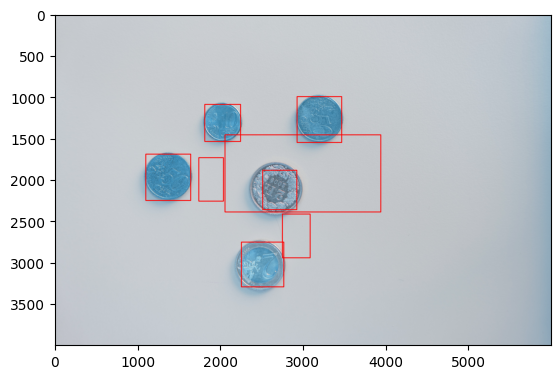

In [ ]:
image = neutral_bg_sample.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detected_coins_image, contours = apply(image)

plt.imshow(detected_coins_image)

## Training ResNet-50 for object localization

Time was running out, and classical segmentation methods were too sensitive to the parameters. We went with a transfer learning approach to find the bounding boxes of coins, i.e. object localization. In this sense, we went with ResNet-50, pre-trained on ImageNet, with size [97.8MB](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html).

More specifically, we are using the [faster R-CNN model with a ResNet50 backbone](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html).

Region-based Convolutional Neural Networks (R-CNN) is specifically to tackle object detection in computer vision tasks. Faster R-CNN is not strictly necessary, but it potentially lets us generalize the application to real-time coin detection in the future.

Moreover, ResNet50 is a residual neural network. It is quite deep (50 layers) which helps it learn more detailed features of the image. Since our images are quite noisy and contains a lot of variation, this will make it more accurate for coin localization. Moreover, it is also one of the only two provided pre-trained models from PyTorch.



**IMPORTANT:** The folder structure of the training dataset must follow exactly:
```
dataset
├── images
│   ├── L1010277.JPG
├── annotations
│   ├── L1010277 [1].xml
```


### Prepare the labelled training dataset into the required format

In [ ]:
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
from PIL import Image


In [ ]:
# File folder organization
unlabeled_data_folder = os.path.join("Data", "train")

data_labels_folder = os.path.join("Labelled_Training_Data")

coin_detection_dataset = os.path.join("dataset")
coin_detection_images = os.path.join("dataset", "images")
coin_detection_annotations = os.path.join("dataset", "annotations")
os.makedirs(coin_detection_dataset, exist_ok=True)
os.makedirs(os.path.join(coin_detection_dataset, "images"), exist_ok=True)
os.makedirs(os.path.join(coin_detection_dataset, "annotations"), exist_ok=True)


In [ ]:
import shutil

# Data/train/folder
for folder in os.listdir(unlabeled_data_folder):
    # Labelled_Training_Data/label_folder
    label_folder = os.path.join(data_labels_folder, folder)
    # folder = path to folder
    folder = os.path.join(unlabeled_data_folder, folder)
    for image in os.listdir(folder):
        # Find corresponding XML_file
        for label_file in os.listdir(label_folder):
            # Ex: L1010277.JPG --> L1010277
            if (image[:-4] in label_file):
                label_filepath = os.path.join(label_folder, label_file)
                image_filepath = os.path.join(folder, image)
                shutil.copy2(label_filepath, coin_detection_annotations)
                shutil.copy2(image_filepath, coin_detection_images)

### Setup the model

Here `CoinDataset` is simply helping us parsing the images (.JPG) and annotations (.XML) in order to be fed into the network for training. After that, we will set up the model.

In [ ]:
# Parser for data
class CoinDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        ann_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")

        boxes = []
        tree = ET.parse(ann_path)
        root = tree.getroot()
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background and coin
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Data transforms
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
    ]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

### Train on custom dataset

Run the next cell if you want to train the model on the custom (coins) dataset. This cell actually loads in the data and starts the training for 10 epochs.

In [ ]:
# Load the dataset
dataset = CoinDataset("dataset/", transforms=transforms)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

# Fine-tune the model based on our labelled training data
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print("Beginning epoch", epoch + 1)
    for i, (images, targets) in enumerate(data_loader, 0):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        if i % 10 == 9:  # Print every 10 batches
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(data_loader)}], Loss: {running_loss/10:.4f}"
            )
            running_loss = 0.0

print("Training finished.")

# Save the trained model
torch.save(model.state_dict(), "coin_detector.pth")

### (Optional) Load an existing model

Uncomment and run the next cell if you already have a trained model, and skip the above cell. This is to prevent having to re-train the model every time we restart the kernel. Make sure `coin_detector.pth` is in the root folder.

In [ ]:
# import torch
# import torch.utils.data
# import torchvision
# from torchvision.models.detection import fasterrcnn_resnet50_fpn
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# import xml.etree.ElementTree as ET
# from PIL import Image

# # Load the trained model
# model = fasterrcnn_resnet50_fpn(pretrained=True)
# num_classes = 2  # Background and coin
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# model.load_state_dict(torch.load("coin_detector.pth"))

### Perform object localization on test images

This will predict bounding boxes on the images, crop the coins out for each image and save them to an output folder.

**IMPORTANT:** The folder structure of input test images must follow exactly:
```
data
├── test
│   ├── L1010277.JPG
│   ├── L1010239.JPG
```
And the folder structure of output images will be:
```
output
├── L0000000.JPG                        <---------------- This is a directory
│   ├── 1920_1519_2595_2181.jpg         <---------------- This is an image of the 1st cropped coin, belonging to L0000000.JPG
│   ├── 2780_2159_3326_2685.jpg         <---------------- This is an image of the 2nd cropped coin, belonging to L0000000.JPG
├── L0000001.JPG                        
│   ├── 1920_1519_2595_2181.jpg         
│   ├── 2780_2159_3326_2685.jpg         
```
If an "output" folder already exists, it will get overwritten.

In [ ]:
# Perform inference on test images
model.eval()
test_data_path = "Data/test"

os.makedirs("output", exist_ok=True)
for img_name in os.listdir(test_data_path):
    img_path = os.path.join(test_data_path, img_name)
    # Check if the file is an image
    if not img_name.endswith(".JPG") and not img_name.endswith(".jpg"):
        continue
    img = Image.open(img_path).convert("RGB")
    img_tensor = transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
    # Create a directory for each image, where cropped coins will be saved
    os.mkdir(f"output/{img_name}")
    boxes = outputs[0]["boxes"].cpu().numpy()
    # Crop coins from current image
    for box in boxes:
        xmin, ymin, xmax, ymax = box.astype(int)
        coin = img.crop((xmin, ymin, xmax, ymax))
        cropped_coin_path = os.path.join(
            f"output/{img_name}", f"{xmin}_{ymin}_{xmax}_{ymax}.jpg"
        )
        coin.save(cropped_coin_path)

# Classification

## Importing data

In [ ]:
import os
import cv2 as cv

images_classes_path = "./Extracted_Training_data"
image_classes_list = os.listdir(images_classes_path)
num_classes = len(image_classes_list)
print("total {} classes".format(num_classes))

test_images_path = "output"
images_dict = {}
image_name_list = os.listdir(test_images_path)
for image_folder in image_name_list:
    images_dict[image_folder] = []
    images_path = os.path.join(test_images_path, image_folder)
    # Check if the path is a directory
    if not os.path.isdir(images_path):
        continue
    for image in os.listdir(images_path):
        path_to_coin_image = os.path.join(images_path, image)
        images_dict[image_folder].append(path_to_coin_image)
num_images = len(image_name_list)
print("total {} test images".format(num_images))

## Data augmentation

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
!rm -rf ./logs/

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.image as mpimg
import numpy as np


### Import Required Libraries
This section imports the necessary libraries for image processing and augmentation `ImageDataGenerator`and related functions from `tensorflow.keras.preprocessing.image` are used for loading and augmenting images. The `os` module handles directory operation, and `tqdm` provides a progress bar for the augmentation process.

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image
import os
from tqdm import tqdm
import random

### Initialize the ImageDataGenerator

An instance of `ImageDataGenerator`is created with specific augmentation parameters. The purpose of this data augmentation is to artificially expand the training dataset by generating new, altered versions of the existing coin images. This is particularly beneficial since our original training dataset is small, so augmentation will help to prevent overfitting and improve the model's ability to generalize to new data. 

For this task, the chosen augmentations are Rescaling, Rotation, Brightness Adjustment and Zoom. Rescaling of pixel values from [0,255] range to [0,1] is done to facilitate faster convergence during training. We apply a random rotation of up to 90 degrees as well, this is to make the model robust to changes in orientation, improving its ability to recognize coins regardless of rotation. Since lighting conditions vary slightly in the training data a brightness adjustment is also implemented. Finally a slight zoom in is implemented since the segmentation algorithm can cut of some edges of coins and therefore preparing the model for that in the training data makes generalize better to the test dataset.


In [ ]:

# Create the directories to save the augmented images
augmented_data_path = 'path_to_save_augmented_images'
os.makedirs(augmented_data_path, exist_ok=True)

crazy_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    zoom_range=[0.8, 1.2],
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
)


### Augment and Save Images
This loop iterates over each class directory and each image within that directory. Each image is loaded and converted to an array. The `datagen.flow` function generates augmented images which are saved to the specified directory.

In [ ]:
# Set the number of augmented images to generate per original image
num_augmented_images = 10

# Load the original images
original_data_path = images_classes_path

# Calculate the total number of files
all_files = sum([len(files) for r, d, files in os.walk(original_data_path)])
pbar = tqdm(total=all_files * num_augmented_images, desc="Augmenting images")

for class_dir in os.listdir(original_data_path):
    class_path = os.path.join(original_data_path, class_dir)
    save_class_path = os.path.join(augmented_data_path, class_dir)
    os.makedirs(save_class_path, exist_ok=True)
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        
        # Generate and save augmented images
        i = 0
        for batch in crazy_datagen.flow(x, batch_size=1, save_to_dir=save_class_path, save_prefix='aug', save_format='jpeg'):
            i += 1
            pbar.update(1)
            if i >= num_augmented_images:
                break

pbar.close()

### Define Data generators for Training and validation
Two data generators are defined: one for training and one for validation. The images are rescaled, and the dataset is split into training and validation subsets. The images are resized to 224x224 picels, and a batch size of 32 is used. Different batch sizes were tested, but 32 was found to be a suitable batch size because of the small dataset.

In [ ]:
# Define the data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_generator = datagen.flow_from_directory(
    augmented_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset="training"
)

val_generator = datagen.flow_from_directory(
    augmented_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

# # Test data generator remains the same
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     test_images_path,
#     target_size=(224, 224),
#     shuffle=False,
#     batch_size=1,
#     class_mode='categorical'
# )

# # Get filenames and number of samples
# filenames = test_generator.filenames
# nb_samples = len(filenames)



### Validate Data Generators

In [ ]:
# Print a batch for verification
x_batch, y_batch = next(train_generator)
print(f"Batch x_shape: {x_batch.shape}, Batch y_shape: {y_batch.shape}")

# Verify the data generators
train_batch = next(iter(train_generator))
val_batch = next(iter(val_generator))
print(train_batch[0].shape, train_batch[1].shape)
print(val_batch[0].shape, val_batch[1].shape)

print(f"Steps per epoch: {train_generator.samples // train_generator.batch_size}")
print(f"Validation steps: {val_generator.samples // val_generator.batch_size}")

## Model configuration using Xception

In [ ]:
import keras
from keras.layers import Input
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

### Loading and Customizing InceptionV3 Base Model
The pre-trained InceptionV3 model is loaded with weights from ImageNet, excluding the top fully connected layers. This allows us to customize the output layers for the coin classification task. 

In [ ]:
# from keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import EfficientNetB0
from keras.applications.xception import Xception
# base_model = InceptionV3(include_top=False, # Since we will create our own
#                     weights='imagenet', 
#                     input_shape=(224, 224, 3))
# base_model.summary()

# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.summary()

# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.summary()

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

### Building the Custom Output Layers

The ouput of the IncdeptionV3 base model is passed through a series of custom layers:

**Flatten:** Converst the feature maps to a 1D feature vector\
**BatchNormalization:** Normalizes the activations to improve training stability\
**Dense (512 units):** Fully connected layer with ReLy activation\
**Dropout (50%):** Regularization technique to prevent overfitting\
**Dense (num_classes):** Output layer with softmax actiavtion for the final coin classification

In [ ]:
# x = inceptionv3_base.output
# # x = Flatten()(x)
# # x = BatchNormalization()(x)
# # x = Dense(512, activation='relu')(x)
# # x = Dropout(rate = .5)(x)
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.3)(x)
# predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=predictions)
model.summary()

### Freezing of Base layers

This block freezes all the layer except the last 7 in order to retrain the pre-trained weights during initial training. The last 7 layers remain trainable to fine-tune them for coin classification. 

In [ ]:
# Freezing in order to only train the last 7 layers
for layer in model.layers[:]:
    layer.trainable = True
for layer in model.layers[:-10]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
model.summary()


### Compiling the Model
The model is compiled with the Adam optimizer, which is chosen for its efficiency and adaptability. The learning rate is set to 0.0001. The loss function is categorical cross-entropy, which is suitibla for the multi-class coin classification. 

In [ ]:
optimizer = Adam(learning_rate=0.0001)
# optimizer = SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Setting Up Callbacks
Three callbacks are defined to enhance the training process:

**ModelCheckpoint:** Saves the model with the best validation accuracy\
**TensorBoard:** Logs training metrics for visualization.\
**EarlyStopping:** Stops training if the validation does not improve for 6 consecutive epochs, restoring the best weights.\

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint('model.keras',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


my_callbacks = [checkpoint, tensorboard_callback, early_stopping_callback]

### Training the Model

In [ ]:
history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=15,
          callbacks=my_callbacks)
print('Training done!')


In [ ]:
# model_label = ""
# model.save(model_label)

In [ ]:
for layer in model.layers[:]:
    layer.trainable = True

In [ ]:
params = model.fit(train_generator, 
                                validation_data=val_generator, 
                                epochs=30,
                                callbacks=my_callbacks)

## Plot accuracies and losses

In [ ]:
def plot_history(history):
    acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'history' is the History object returned from model.fit
plot_history(history)
plot_history(params)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
import os
import time
import subprocess
from IPython.display import display, HTML

os.system('pkill -f "tensorboard"')
subprocess.Popen(["tensorboard", "--logdir", "logs/fit"])
time.sleep(5)
display(HTML(f'<a href="http://localhost:6006" target="_blank">Open TensorBoard</a>'))

## Use model on given test images


In [ ]:
def predict_images(path, verbose=False, show_image=False):
    # Load and display the image
    img = mpimg.imread(path)

    if show_image:
        plt.imshow(img)
        plt.axis('off')  # Hide axis
        plt.show()

    # Preprocess the image
    image = Image.open(path)
    image = image.convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Expand dimensions to fit model input

    # Predict the probabilities
    probabilities = model.predict(image, verbose=0)

    # Get class labels
    class_labels = {v: k for k, v in val_generator.class_indices.items()}

    # Prepare data for a nice display
    sorted_indices = np.argsort(probabilities[0])[::-1]
    results = [(class_labels[i], probabilities[0][i]) for i in sorted_indices]

    # Print sorted probabilities and their corresponding class labels
    if verbose:
        print("Class".ljust(15), "Probability")
        print("-" * 30)
        for label, prob in results:
            print(f"{label.ljust(15)} : {prob:.4f}")

    # Return the class label with the highest probability
    return results[0][0]

In [ ]:
# For processing submission
import pandas as pd

# This will used as a template to build the submission.
if not os.path.exists("sample_submission.csv"):
    raise FileNotFoundError("sample_submission.csv not found!")
submission = pd.read_csv("sample_submission.csv")
submission.head()

# Perform prediction on all test images.
for key in images_dict:
    labels_count = {key: 0 for key in image_classes_list}
    for coin_path in images_dict[key]:
        predicted_class = predict_images(coin_path, verbose=True, show_image=True)
        labels_count[predicted_class] += 1

    row_to_write = submission.loc[submission["id"] == key[:-4]]

    for label in labels_count:
        row_to_write[label] = labels_count[label]

    submission.loc[submission["id"] == key[:-4]] = row_to_write


# Save the submission
submission.to_csv("submission.csv", index=False)

## Confusion matrix on validation set

In [ ]:
import pandas as pd
import seaborn as sns

Y_pred = model.predict(val_generator, 1167//32+1)
y_pred = np.argmax(Y_pred, axis=1)
cfm = confusion_matrix(val_generator.classes, y_pred)
cfm = np.around(cfm.astype('float')/cfm.sum(axis=1)[:, np.newaxis], decimals=2)
classes = ['0.1CHF', '0.1EUR', '0.01EUR', '0.2CHF', '0.2EUR', '0.02EUR', '0.5CHF', '0.05CHF', '0.5EUR', '0.05EUR', '1CHF', '1EUR', '2CHF', '2EUR', '5CHF', 'OOD']
cfm_pd = pd.DataFrame(cfm, index = classes, columns = classes)
figure = plt.figure(figsize=(8,8))
sns.heatmap(cfm_pd, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
